![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=Vertex+AI+Pipelines+-+Prophet.ipynb)

# Vertex AI Pipelines - Prophet

In the [Vertex AI Custom Model - Prophet - In Notebook](./Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20In%20Notebook.ipynb) and [Vertex AI Custom Model - Prophet - Custom Job With Custom Container](./Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20Custom%20Job%20With%20Custom%20Container.ipynb) notebooks, [Prophet](https://github.com/facebook/prophet) was used to fit a forecasting model to citibike bike rentals daily volume data prepared in the [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb).

This notebook uses a [Vertex AI Pipeline](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) that is pre-built to handle the code behind building the forecasting model and retrieving predictions from it.  It actually does much more like parallel fitting of multiple time series, back testing of the forecasting algorithm in specified windows as well as hyperparameter tuning with a grid search over the [parameters recommended by the Prophet documentation](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning).    

This uses Prophet but orchestrates the steps with a pipeline built with the [Kubeflow Pipelines SDK](https://www.kubeflow.org/docs/components/pipelines/v2/introduction/) and runs in the managed environment of Vertex AI Pipelines.  Pipeline steps run in components which run associated code in a related container.  While these components can be custom built by the user, in this case, the pipeline is completely [pre-built](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction) so only inputs to functions are needed to drive the pipeline execution.

---

**Series Overview**

[This series](./readme.md) explores forecasting with Vertex AI, BigQuery ML, and additional open source frameworks.  Forecasting consist of following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Some method also incoporate observable measurements that impact demand to understand the relationships and make forecasting more accurate.

**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at:: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`

**Prophet**

[Prophet](https://github.com/facebook/prophet) is an open-source solution for custom forecasting.  Prophet is built on [Stan](https://mc-stan.org/), a probabalistic programming language, and has been implemented in Python and R.  Prophet is built to be robust to outliers and missing data while also being customizable where you can add domain knowledge about the forecasting.
- [Prophet Research Paper](https://peerj.com/preprints/3190/)
- [Prophet Documentation](https://facebook.github.io/prophet/docs/quick_start.html)

---

**Prerequisites:**
- [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

**Resources**
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Python Client](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [SQL Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)
    - [Vertex AI Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest)
    - [Vertex AI Forecasting Pipelines Prophet](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting-prophet)
    - Google Cloud Pipeline Components (pre-built):
        - [Documentation](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction)
        - [SDK Reference](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.41/)
- Prophet
    - [Prophet Paper](https://peerj.com/preprints/3190/)
    - [Documentation](documentation)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20Pipelines%20-%20Prophet.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [1]:
# tuples of (import name, install name)
packages = [
    ('google_cloud_pipeline_components', 'google-cloud-pipeline-components'),
    ('plotly', 'plotly'),
    ('kaleido', 'kaleido')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [2]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

### Package Installs

This notebook uses [Google Cloud Pipeline Components](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction) that are pre-built.  In order to use these install 

In [3]:
try:
    import google_cloud_pipeline_components
except ImportError:
    !pip install google-cloud-pipeline-components -q

### Environment

inputs:

In [4]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [5]:
REGION = 'us-central1'
EXPERIMENT = 'pipeline-prophet'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

packages:

In [6]:
from google.cloud import bigquery
from google.cloud import aiplatform

#from google_cloud_pipeline_components.experimental.automl.forecasting import utils
from google_cloud_pipeline_components.v1.automl.forecasting import utils

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

clients:

In [7]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [8]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [9]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

---
## Review Time Series

**Univariate Forecasting** consists of just 2 columns per time series:
- `TARGET_COLUMN` = The demand measurment.
    In our case it is the number of trips taken per day from a particular bike station - the sum of trips for a day.
- `TIME_COLUMN` = The time of demand.
    Expressed in the time or date units related to the granularity of the forecast exercise.  In our case, demand is measured daily so the time column is prepared as a date.

**Additional Columns** are used to instruct the forecasting algorithms handling of the data:
- `SERIES_COLUMN` groups rows associated with the same time series.
    - Conducting multiple forecasts, one per time series, means including a third column to capture the groups of row for each time series: `SERIES_COLUMN`.
    - **NOTE:** Prophet fits a separate forecast for each of these groups.  In our case this is the `start_station_name` or name for each individual Citibike station near Central Park.
- `SPLITS_COLUMN` groups sequential rows within each time series for their purpose during the forecasting exercise.
    - This data was prepared with splits for `TRAIN`, `VALIDATE` and `TEST` in the prerequisite notebooks.  The column that contains these splits can be used by the choosen forecast method during training rather than have the method calculate the splits.  This can be helpful when comparing multiple different methods as it ensures splitting is handled the same across each method.
    
**Forecasting Parameters**:
- `FORECAST_GRANULARITY` is the frequency of measurment like MINUTE, HOUR, DAY, WEEK, MONTH, YEAR
    - The data was summarized at the DAY level in the data preparation notebook
    - This is the amount of time between measurments - rows  
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.
    - specification of granularity differs by method:
        - BigQuery ML: PER_MINUTE, HOURLY, DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY
        - Prophet (including Vertex Pre-Built Pipelines): minute, hour, day, week, month, or year
        - Vertex AI AutoML: minute, hour, day, week, month, year
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).
- `FORECAST_TEST_LENGTH` is the number of rows allocated to the test region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'TEST'` values for each time series in `SERIES_COLUMMN`.
- `FORCAST_VALIDATE_LENGTH` is the number of rows allocated to the validation region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'VALIDATE'` values for each time series in `SERIES_COLUMN`.
- `FORECAST_HORIZON_LENGTH` is the number of rows to forecast into the future beyond the test region
    - This is in the units of `FORECAST_GRANULARITY`
    - This needs to be set as an input to the forecast method

In [10]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'

# CUSTOMIZE
FORECAST_GRANULARITY = 'day' # the data preparation included preparing the data at this level
    # note that the prophet pipeline will not accept DAY, as it expect lowercase day
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

Retrieve Key Dates from splits.  The splits were defined when the data was processed by the prerequisite notebook.  This will retrieve information from the prepared data:

In [11]:
query = f"""
    WITH
        SPLIT AS (
            SELECT {SPLIT_COLUMN}, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

Correct the set values of `FORECAST_TEST_LENGTH` and `FORECAST_VALIDATE_LENGTH` to match the prepared data:

In [12]:
if FORECAST_TEST_LENGTH != (keyDates['end_date'][0] - keyDates['test_start'][0]).days + 1:
    FORECAST_TEST_LENGTH = (keyDates['end_date'][0] - keyDates['test_start'][0]).days + 1
    
if FORECAST_VALIDATE_LENGTH != (keyDates['test_start'][0] - keyDates['val_start'][0]).days:
    FORECAST_VALIDATE_LENGTH = (keyDates['test_start'][0] - keyDates['val_start'][0]).days
    
print('FORECAST_TEST_LENGTH is ', FORECAST_TEST_LENGTH)
print('FORECAST_VALIDATE_LENGTH is ', FORECAST_VALIDATE_LENGTH)

FORECAST_TEST_LENGTH is  14
FORECAST_VALIDATE_LENGTH is  14


Retrieve raw data:

In [13]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {SPLIT_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

In [14]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


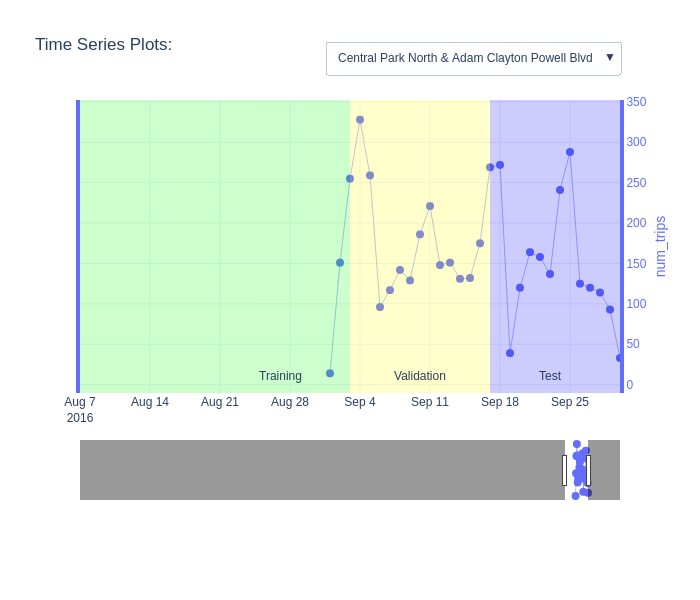

In [15]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Create Forecast Model

In this notebook and open-source solution named [Prophet](https://github.com/facebook/prophet) is utlized for custom forecasting.  Prophet is built on [Stan](https://mc-stan.org/), a probabalistic programming language, and has been implemented in Python and R.  Prophet is built to be robust to outliers and missing data while also being customizable where you can add domain knowledge about the forecasting.

### Training Pipeline

#### Create the Training Pipeline Specifications

Rather than directly interacting with Prophet as was done in the [Vertex AI Custom Model - Prophet - In Notebook](./Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20In%20Notebook.ipynb) notebook and the [Vertex AI Custom Model - Prophet - Custom Job With Custom Container](./Vertex%20AI%20Custom%20Model%20-%20Prophet%20-%20Custom%20Job%20With%20Custom%20Container.ipynb) notebook, this example uses a prebuilt pipeline running on Vertex AI Pipelines.  This means just providing parameters and letting it do the coding work on our behalf.  It actually does much more like parallel fitting of multiple time series, back testing of the forecasting algorithm in specified windows as well as hyperparameter tuning with a grid search over the [parameters recommended by the Prophet documentation](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning).

Link to SDK for [utils.get_prophet_train_pipeline_and_parameters](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.41/google_cloud_pipeline_components.experimental.automl.forecasting.html#google_cloud_pipeline_components.experimental.automl.forecasting.utils.get_prophet_train_pipeline_and_parameters)

In [16]:
train_job_spec_path, train_parameter_values = utils.get_prophet_train_pipeline_and_parameters(
    root_dir = f'gs://{PROJECT_ID}/{SERIES}/{EXPERIMENT}',
    project = PROJECT_ID,
    location = REGION,
    time_column = TIME_COLUMN,
    time_series_identifier_column = SERIES_COLUMN,
    target_column = TARGET_COLUMN,
    forecast_horizon = FORECAST_HORIZON_LENGTH,
    data_granularity_unit = FORECAST_GRANULARITY,
    predefined_split_key = SPLIT_COLUMN,
    data_source_bigquery_table_path = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}',
    window_stride_length = 1,
    
    trainer_dataflow_machine_type = "n1-standard-2",
    trainer_dataflow_max_num_workers = 5,
    evaluation_dataflow_machine_type = "n1-standard-1",
    evaluation_dataflow_max_num_workers = 1,
    dataflow_service_account = SERVICE_ACCOUNT,
    
    max_num_trials = 2,
    optimization_objective = 'rmse'
)

#### Run The Training Pipeline

Link to SDK for [aiplatform.PipelineJob()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

In [17]:
training_pipeline_job = aiplatform.PipelineJob(
    job_id = f'{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    display_name = f'{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    pipeline_root = f'gs://{PROJECT_ID}/{SERIES}/{EXPERIMENT}/pipeline_root',
    template_path = train_job_spec_path,
    parameter_values = train_parameter_values
)

Link to SDK for:
- [aiplatform.PipelineJob.submit()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_submit)
    - Runs and does not wait
- [aiplatform.PipelineJob.run()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_run)
    - Runs and waits will reporing progress in the log

In [18]:
training_pipeline_job.submit(
    service_account=SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/applied-forecasting-pipeline-prophet-20231210193806?project=1026793852137


In [19]:
print(f'The Dashboard can be viewed here:\n{training_pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/applied-forecasting-pipeline-prophet-20231210193806?project=1026793852137


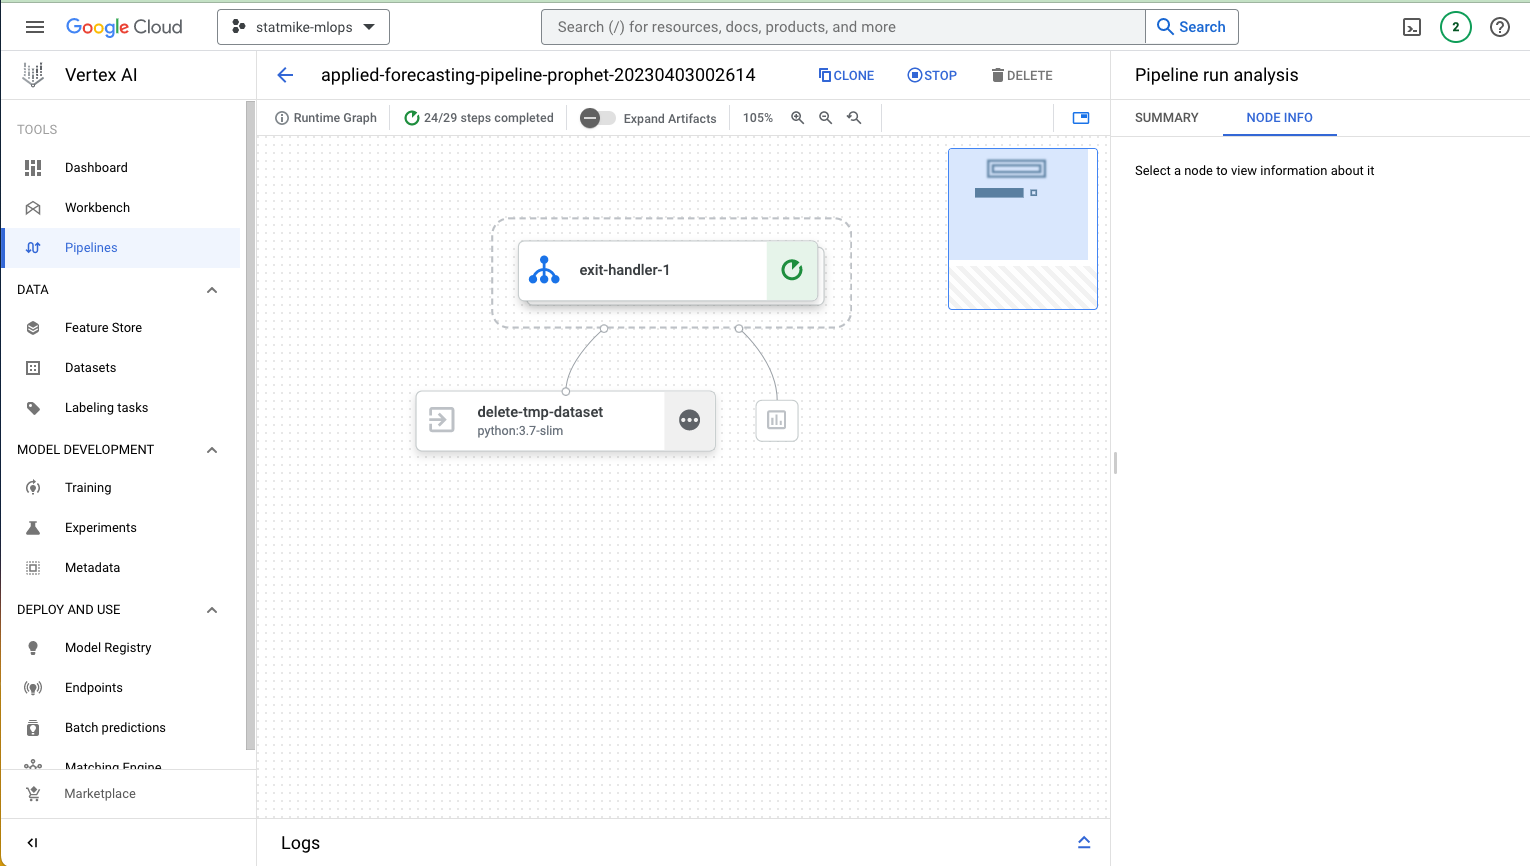
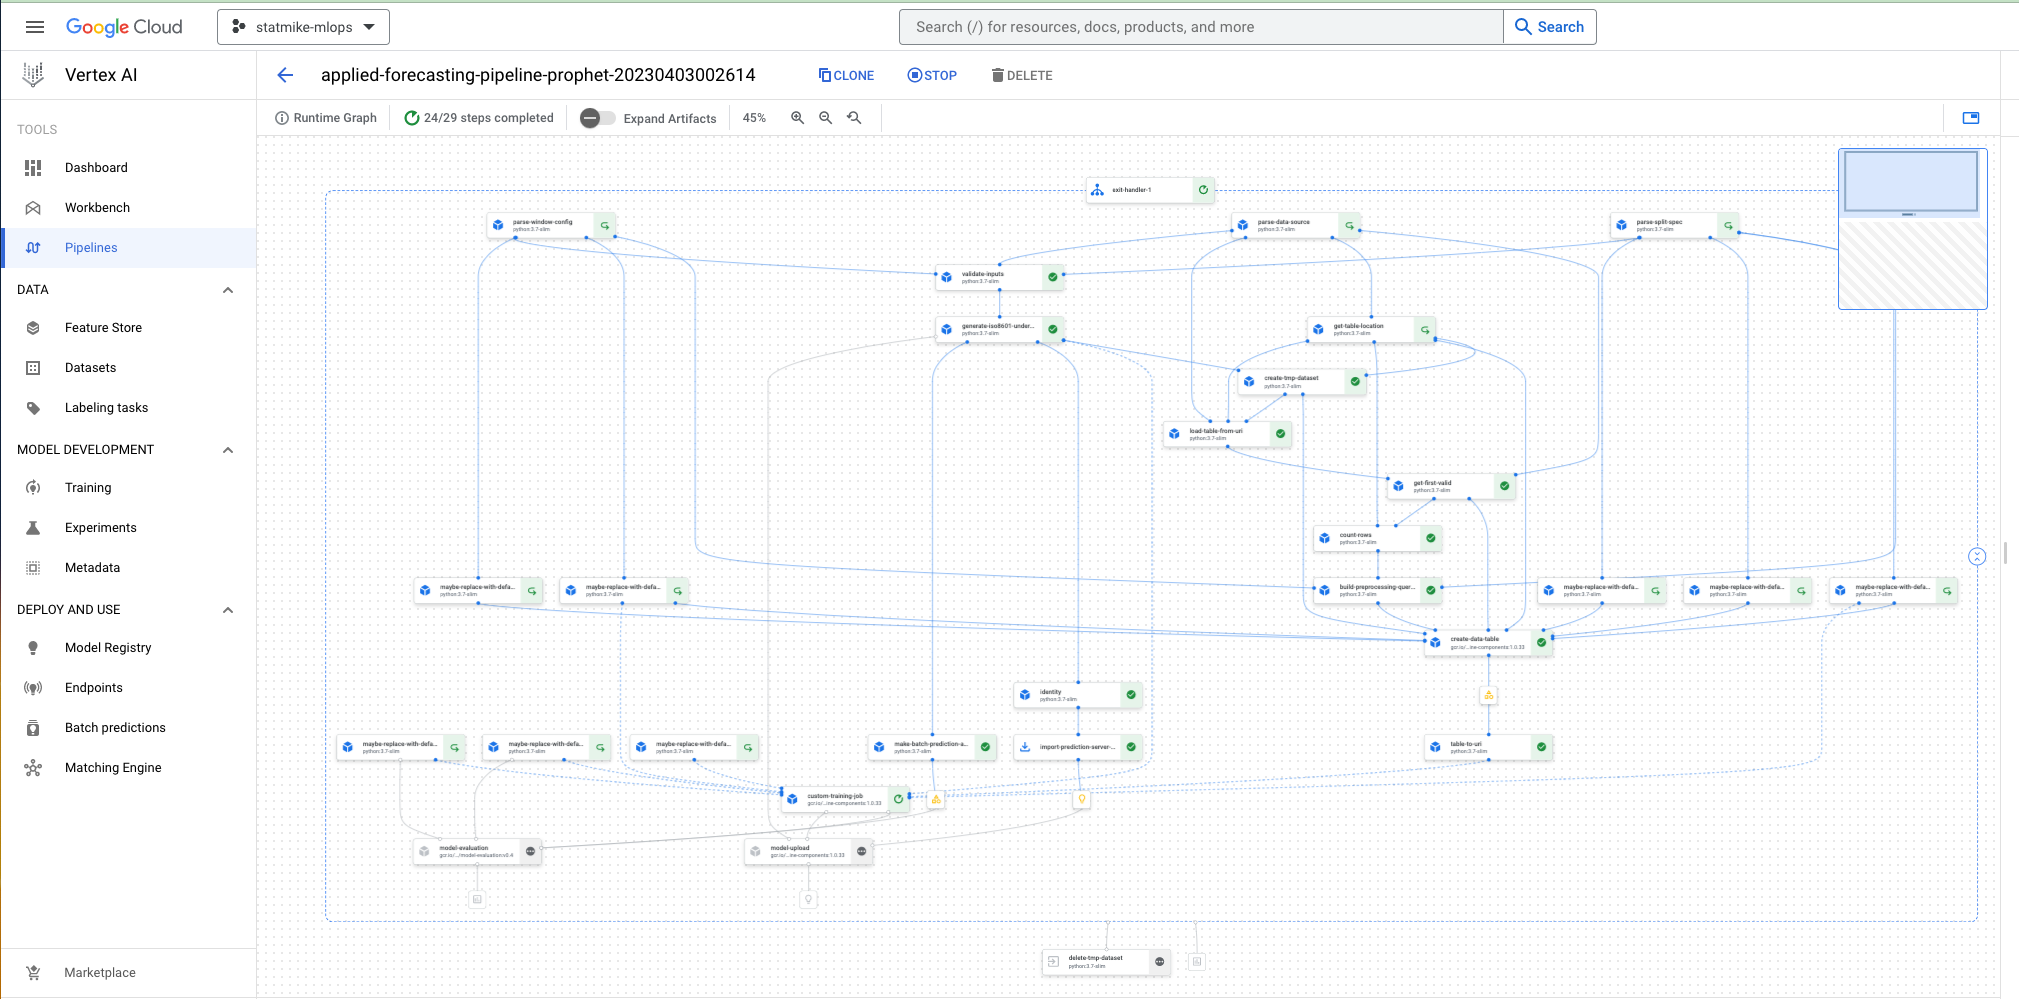

#### Wait On Training Pipeline Job

In [20]:
training_pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-prophet-20231210193806 current 

#### Review Training Pipeline Job

In [23]:
aiplatform.get_pipeline_df(pipeline = f'prophet-train').head(1)

pipeline_name                                           run_name  \
0  prophet-train  applied-forecasting-pipeline-prophet-202312101...   

  param.input:evaluation_dataflow_max_num_workers param.input:window_column  \
0                                             1.0                             

                param.input:dataflow_service_account  \
0  1026793852137-compute@developer.gserviceaccoun...   

  param.input:evaluation_dataflow_machine_type  \
0                                n1-standard-1   

  param.input:dataflow_use_public_ips param.input:location  \
0                                True          us-central1   

  param.input:trainer_dataflow_disk_size_gb  \
0                                      40.0   

  param.input:data_source_csv_filenames  ...    param.input:project  \
0                                        ...  statmike-mlops-349915   

  param.input:encryption_spec_key_name param.input:timestamp_split_key  \
0                                                                        

  param.input:bigquery_destination_uri param.input:trainer_service_account  \
0                                  NaN                                 NaN   

  metric.rSquared metric.meanAbsolutePercentageError  \
0             NaN                                NaN   

   metric.rootMeanSquaredLogError metric.meanAbsoluteError  \
0                             NaN                      NaN   

  metric.rootMeanSquaredError  
0                         NaN  

[1 rows x 40 columns]

#### List The Pipeline Tasks

In [27]:
for task in training_pipeline_job.gca_resource.job_detail.task_details:
    print(task.task_name)

model-upload
wrapped-in-list
exit-handler-1
condition-2
table-to-uri
bigquery-query-job
model-evaluation-regression
applied-forecasting-pipeline-prophet-20231210193806
get-fte-suffix
get-table-location
validate-inputs
bigquery-delete-dataset-with-prefix
build-job-configuration-query
prophet-trainer
bigquery-create-dataset
feature-transform-engine


#### Get The Model Evaluation

The parameters from the pipeline job can be individually retrieved from component ouputs also:

In [28]:
for task in training_pipeline_job.gca_resource.job_detail.task_details:
    if task.task_name == "model-evaluation-regression":
        metrics = task.outputs["evaluation_metrics"].artifacts[0].metadata
        break
else:
    raise ValueError("Not Found.")
    
dict(metrics)

{'meanAbsoluteError': 40.0836,
 'meanAbsolutePercentageError': 67.796425,
 'rootMeanSquaredError': 61.072044,
 'rootMeanSquaredLogError': 0.5952818,
 'rSquared': 0.58523476}

#### Get The Prophet Model

The training pipeline registered the final model in the Vertex AI Model Registy

In [29]:
for task in training_pipeline_job.gca_resource.job_detail.task_details:
    if task.task_name == "model-upload":
        model = task.outputs["model"].artifacts[0].metadata["resourceName"]
        break
else:
    raise ValueError("Not Found.")
    
model

'projects/1026793852137/locations/us-central1/models/1106986107821621248'

In [30]:
vertex_model = aiplatform.Model(model)

In [31]:
vertex_model.name, vertex_model.resource_name

('1106986107821621248',
 'projects/1026793852137/locations/us-central1/models/1106986107821621248')

In [32]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{vertex_model.name}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/1106986107821621248?project=statmike-mlops-349915


### Prediction Pipeline

#### Create the Prediction Pipeline Specifications

Link to SDK for [utils.get_prophet_prediction_pipeline_and_parameters](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.41/google_cloud_pipeline_components.experimental.automl.forecasting.html#google_cloud_pipeline_components.experimental.automl.forecasting.utils.get_prophet_prediction_pipeline_and_parameters)

In [61]:
predict_job_spec_path, predict_parameter_values = utils.get_prophet_prediction_pipeline_and_parameters(
    project = PROJECT_ID,
    location = REGION,
    model_name = vertex_model.resource_name,
    time_column = TIME_COLUMN,
    time_series_identifier_column = SERIES_COLUMN,
    target_column = TARGET_COLUMN,
    data_source_bigquery_table_path = f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}',
    bigquery_destination_uri = f"{BQ_PROJECT}.{BQ_DATASET}",
    #machine_type = 'n1-standard-2',
    #max_num_workers = 2
)

#### Run The Prediction Pipeline

Link to SDK for [aiplatform.PipelineJob()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

In [62]:
pipeline_job = aiplatform.PipelineJob(
    #job_id = f'prediction-{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    display_name = f'prediction-{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    pipeline_root = f'gs://{PROJECT_ID}/{SERIES}/{EXPERIMENT}/pipeline_root/prediction',
    template_path = predict_job_spec_path, #+'_new',
    parameter_values = predict_parameter_values
)

Link to SDK for:
- [aiplatform.PipelineJob.submit()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_submit)
    - Runs and does not wait
- [aiplatform.PipelineJob.run()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_run)
    - Runs and waits will reporing progress in the log

In [63]:
pipeline_job.submit(
    service_account=SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/prophet-predict-20231212000650?project=1026793852137


In [64]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/prophet-predict-20231212000650?project=1026793852137


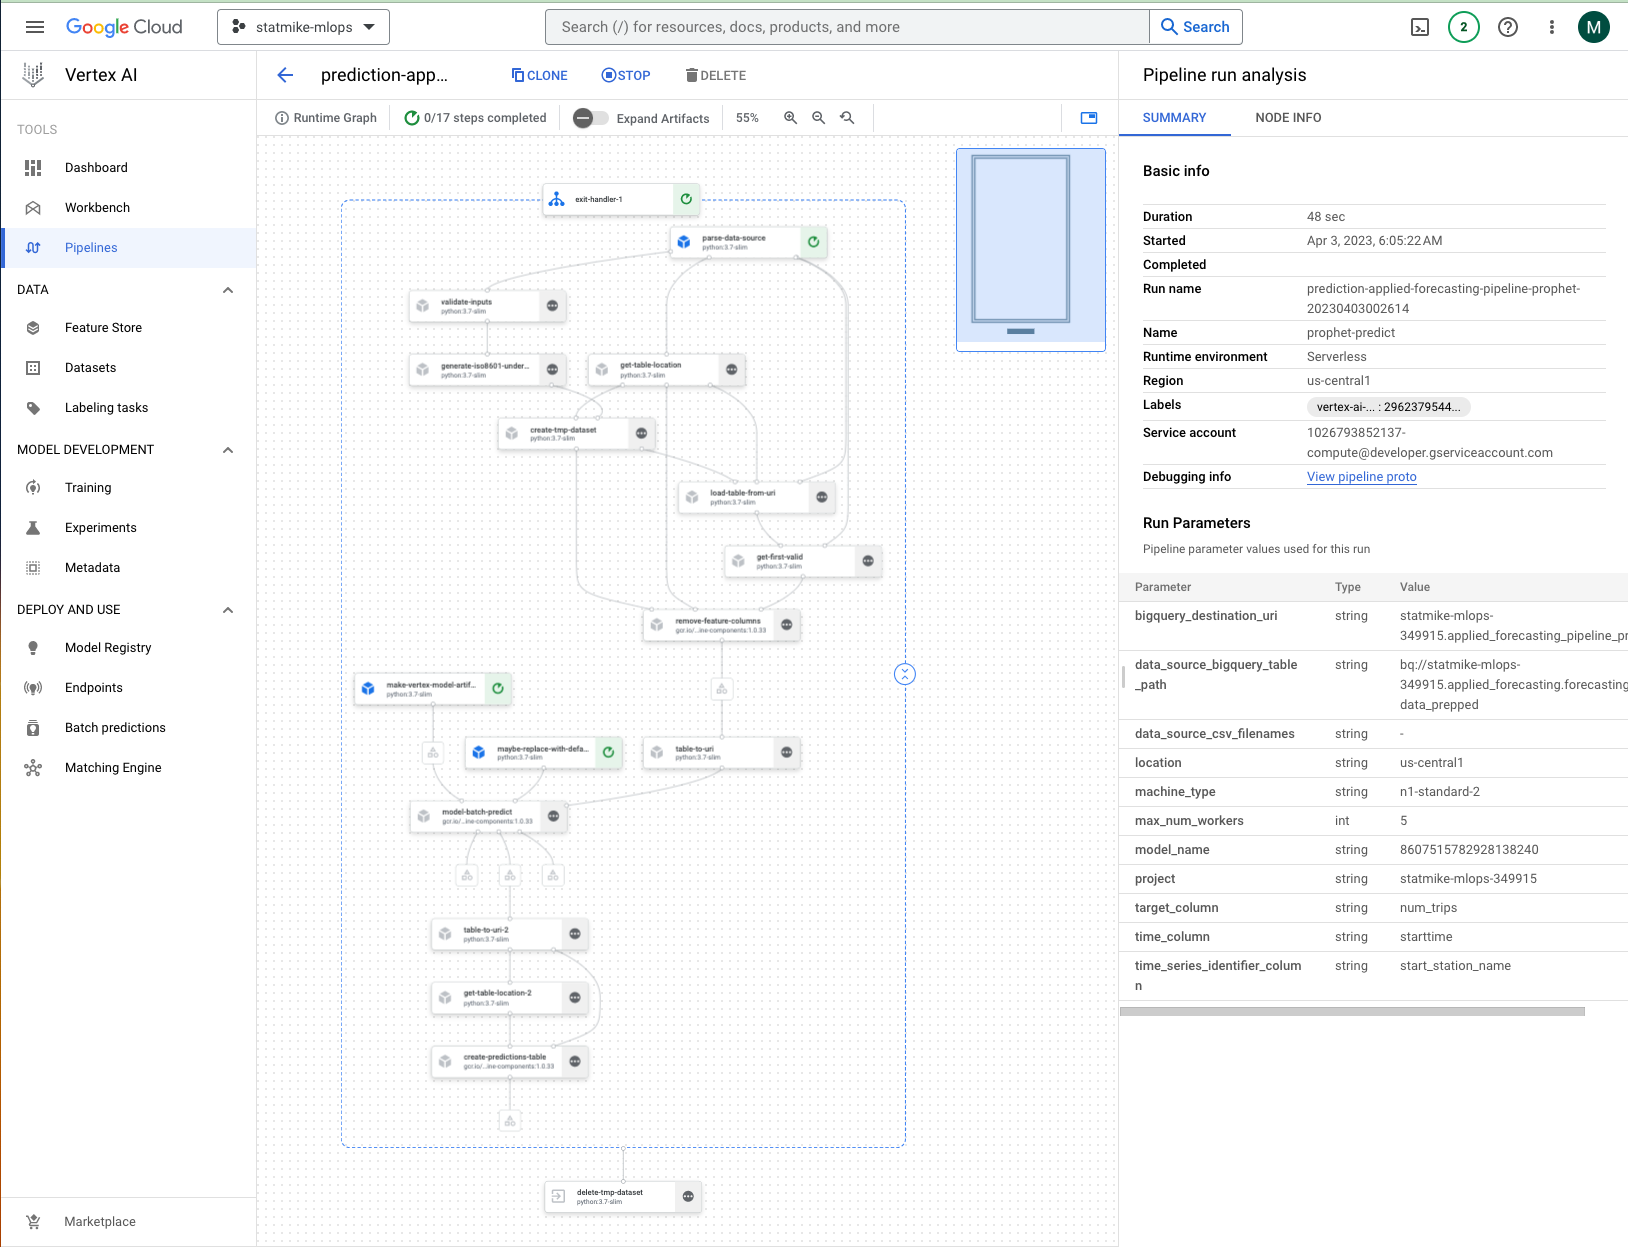

#### Wait On Prediction Pipeline Job

In [ ]:
pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-predict-20231212000650 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prophet-pred

RuntimeError: Job failed with:
code: 9
message: "The DAG failed because some tasks failed. The failed tasks are: [exit-handler-1].; Job (project_id = statmike-mlops-349915, job_id = 7530071628399509504) is failed due to the above error.; Failed to handle the job: {project_number = 1026793852137, job_id = 7530071628399509504}"


#### Review Prediction Pipeline Job

In [ ]:
aiplatform.get_pipeline_df(pipeline = f'prophet-prediction').head(1)

#### Get The Output Table Name

In [ ]:
for task in pipeline_job.gca_resource.job_detail.task_details:
    if task.task_name == "bigquery-query-job-2":
        pred_table = (
            task.outputs["destination_table"].artifacts[0].metadata["tableId"]
        )
        break
else:
    raise ValueError("Not Found.")
    
pred_table

#### Get The Forecasts

In [ ]:
query = f"""
    SELECT *, 
    FROM `{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}.{pred_table}`
"""
predictions = bq.query(query).to_dataframe()

In [ ]:
predictions.head()

## Visualize Time Series With Forecast

## Using SQL to Calculate Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```
